# Week 1

**`Environment::API::observation`**
* prices vector
* returns vector
* last weights

**`Environment::API::multi-agent`**
* rewards `pandas.DataFrame`
* actions `pandas.DataFrame`

**`Environment::GUI::summary`**
* PnL
* asset risk

**`Environment::GUI::trading-signal`**
* **scatter**: varying-intensity

In [1]:
# change current working directory
%cd ..

/Users/alpha/Developer/qtrader


In [2]:
# suppress warning messages
import warnings
warnings.filterwarnings('ignore')

# data provider
from qtrader.envs.data_loader import Finance
# pandas.DataFrame cleaner
from qtrader.utils.pandas import clean
# random trading agent
from qtrader.agents import RandomAgent
# uniform trading agent
from qtrader.agents import UniformAgent
# machine floating-point relative accuracy
from qtrader.utils.numpy import eps

# YAML parser
import yaml

# scientific programming
import numpy as np
import pandas as pd

# OpenAI Gym
import gym

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# fetch configuration file
config = yaml.load(open('config/log/week_1.yaml', 'r'))

# configuration summary
print(f"start date: {config['start_date']}")
print(f"trading frequency: {config['freq']}")
print(f"trading universe: {config['tickers']}")

start date: 2015-01-01
trading frequency: W-FRI
trading universe: ['AAPL', 'GE', 'JPM', 'MSFT', 'VOD', 'GS', 'TSLA', 'MMM']


## `PortfolioVector`

OpenAI Gym Spaces Portfolio Vector Data Structure.

In [4]:
class PortfolioVector(gym.Space):
    """OpenAI Gym Spaces Portfolio Vector Data Structure."""

    def __init__(self, num_instruments):
        """Constructs a `PortfolioVector` object.

        Parameters
        ----------
        num_instruments: int
            Cardinality of universe
        """
        self.low = -np.ones(num_instruments, dtype=float) * np.inf
        self.high = np.ones(num_instruments, dtype=float) * np.inf

    def sample(self):
        """Draw random `PortfolioVector` sample."""
        _vec = np.random.uniform(0, 1.0, self.shape[0])
        return _vec / np.sum(_vec)

    def contains(self, x, tolerance=1e-5):
        """Assert if `x` in space."""
        shape_predicate = x.shape == self.shape
        range_predicate = (x >= self.low).all() and (x <= self.high).all()
        budget_constraint = np.abs(x.sum() - 1.0) < tolerance
        return shape_predicate and range_predicate and budget_constraint

    @property
    def shape(self):
        """Shape of `PortfolioVector` object."""
        return self.low.shape

    def __repr__(self):
        return "PortfolioVector" + str(self.shape)

    def __eq__(self, other):
        return np.allclose(self.low, other.low) and \
            np.allclose(self.high, other.high)

## `TradingEnv`

OpenAI Gym Trading Environment.

In [5]:
class TradingEnv(gym.Env):
    """OpenAI Gym Base Trading Environment."""
    
    # --------------------------------------------------------------------------

    class Record:
        """Local data structure for actions and rewards records."""

        def __init__(self, index, columns):
            # records of actions
            self.actions = pd.DataFrame(
                columns=columns, index=index, dtype=float)
            self.actions.iloc[0] = np.zeros(len(columns))
            self.actions.iloc[0]['CASH'] = 1.0
            # records of rewards
            self.rewards = pd.DataFrame(
                columns=columns, index=index, dtype=float)
            self.rewards.iloc[0] = np.zeros(len(columns))
    
    # --------------------------------------------------------------------------

    def __init__(self,
                 universe = None,
                 prices = None,
                 trading_period = 'W-FRI',
                 **kwargs):
        # either `universe` or `prices` non-None
        if not (universe is None) ^ (prices is None):
            raise ValueError(
                'either `universe` or `prices` should be non-None')
        # set trading period
        self.trading_period = trading_period
        # <prices> provided
        if prices is not None and isinstance(prices, pd.DataFrame):
            # prices table
            self._prices = clean(
                prices.resample(self.trading_period).last())
        # <universe> provided
        elif universe is not None and isinstance(universe, list):
            # fetch prices
            self._prices = clean(
                self._get_prices(universe,
                                 trading_period=self.trading_period, **kwargs))
        # risky assets & cash under consideration
        num_instruments: int = len(self.universe) + 1
        # risky assets & cash portfolio vector
        self.action_space = PortfolioVector(num_instruments)
        # risky assets & cash prices vector
        self.observation_space = gym.spaces.Box(-np.inf,
                                                np.inf,
                                                (num_instruments,),
                                                dtype=np.float32)
        # add cash column
        self._prices['CASH'] = 1.0
        # relative (percentage) returns
        self._returns = self._prices.pct_change()
        # counter to follow time index
        self._counter = 0
        # dictionary of registered agents
        self.agents = {}
        # agent's initial wealth
        self._pnl = pd.DataFrame(index=self.dates, columns=[
                                 agent.name for agent in self.agents])
        # figure & axes placeholders
        self._fig, self._axes = None, None

    @property
    def universe(self):
        """List of instruments universe."""
        return self._prices.columns.tolist()

    @property
    def dates(self):
        """Dates of the environment prices."""
        return self._prices.index

    @property
    def index(self) -> pd.DatetimeIndex:
        """Current index."""
        return self.dates[self._counter]

    @property
    def _max_episode_steps(self) -> int:
        """Number of timesteps available."""
        return len(self.dates)

    def _get_prices(self, universe, trading_period, **kwargs) -> pd.DataFrame:
        return Finance.Prices(universe, freq=trading_period, **kwargs)

    def _get_observation(self) -> object:
        ob = {}
        ob['prices'] = self._prices.loc[self.index, :]
        ob['returns'] = self._returns.loc[self.index, :]
        return ob

    def _get_reward(self, action) -> pd.Series:
        return self._returns.loc[self.index] * action

    def _get_done(self) -> bool:
        return self.index == self.dates[-1]

    def _get_info(self) -> dict:
        return {}

    def _validate_agents(self):
        """Check agents' availability."""
        if len(self.agents) == 0:
            raise RuntimeError('no agent registed in the environment')

    #######
    # API
    #######

    def register(self, agent):
        """Register an `agent` to the environment."""
        # verify interface
        if not hasattr(agent, 'name'):
            raise ValueError('agent must have a `name` attribute.')
        # verify uniqueness
        if agent.name not in self.agents:
            self.agents[agent.name] = self.Record(
                columns=self.universe, index=self.dates)

    def unregister(self, agent=None):
        """Unregister an `agent` from the environment."""
        # when agent=None, unregister all agents
        if agent is None:
            # clean records
            self.agents = {}
            return None
        # verify interface
        if not hasattr(agent, 'name'):
            raise ValueError('agent must have a `name` attribute.')
        # verify availability
        if agent.name in self.agents:
            del self.agents[agent.name]

    def step(self, action):
        """The agent takes a step in the environment.

        Parameters
        ----------
        action: numpy.array | dict
            Portfolio vector(s)

        Returns
        -------
        observation, reward, episode_over, info: tuple
            * observation: object
                Observation of the environment
            * reward: float | dict
                Reward(s) received after this step
            * done: bool
                Flag for finished episode
            * info: dict
                Information about this step
        """
        self._validate_agents()
        # timestep
        self._counter += 1
        # fetch return values
        observation = self._get_observation()
        done = self._get_done()
        info = self._get_info()
        # verify interface
        if action.keys() != self.agents.keys():
            raise ValueError(
                'invalid interface of actions provided'
            )
        # container
        reward = {}
        # iterate over agents
        for name, A in action.items():
            # action validity check
            if not self.action_space.contains(A):
                raise ValueError(
                    'invalid `action` attempted: %s' % (A)
                )
            # actions buffer
            self.agents[name].actions.loc[self.index] = A
            self.agents[name].rewards.loc[self.index] = self._get_reward(A)
            # return value
            reward[name] = self.agents[name].rewards.loc[self.index].sum()
        return observation, reward, done, info

    def reset(self) -> object:
        """Reset the state of the environment and returns an initial observation.

        Returns
        -------
        observation: object
            The initial observation of the space.
        """
        self._validate_agents()
        # set time to zero
        self._counter = 0
        # get initial observation
        ob = self._get_observation()
        return ob

    def render(self) -> None:
        """Graphical interface of environment."""
        # initialize figure and axes
        if self._fig is None or self._axes is None:
            # figure & axes for render()
            self._fig, self._axes = plt.subplots(ncols=2, figsize=(19.2, 4.8))
        #
        _pnl = pd.DataFrame(columns=self.agents.keys(),
                            index=self.dates)
        # calculate PnL
        for agent in self.agents:
            # collapse date-wise rewards
            _pnl[agent] = (self.agents[agent].rewards.sum(
                axis=1) + 1).cumprod()
        # remove everything from the axes
        self._axes[0].clear()
        self._axes[1].clear()
        # axes content
        self._prices.loc[:self.index].plot(ax=self._axes[0])
        _pnl.loc[:self.index].plot(ax=self._axes[1])
        # axes settings
        self._axes[0].set_xlim(self.dates.min(),
                               self.dates.max())
        self._axes[0].set_title('Market Prices')
        self._axes[0].set_ylabel('Prices')
        self._axes[1].set_xlim(self._pnl.index.min(),
                               self._pnl.index.max())
        self._axes[1].set_title('PnL')
        self._axes[1].set_ylabel('Wealth Level')
        # draw throttled
        plt.pause(0.0001)
        self._fig.canvas.draw()

In [6]:
# initialize environment
env = TradingEnv(universe=config['tickers'],
                 trading_period=config['freq'],
                 start_date=config['start_date'],
                 csv=config['csv_file_prices'])
# initialize agent
agent = RandomAgent(action_space=env.action_space)
# register the agent
env.register(agent)

## `observation`

At each timestep, `step(actiion)` or `reset()`, return
a `dict` observation, such that:
* `observation['prices']`: prices vector at last timestep
* `observation['returns']`: returns vector at last timestep

The last weights (i.e. last `action`) could be obtained
for `agent_instance` from:
* `env.agents[agent_instance.name].actions.iloc[-1]`: last weights

It has not been integrated in the `observation` dictionary
since in the **multi-agent** mode different agents
would observe different public states which contradicts with
initial assumptions and environment setting.

In [7]:
# initial observation
observation = env.reset()
# `observation` interface
print(f"type(observation): {type(observation)}")
print(f"observation.keys(): {observation.keys()}")

type(observation): <class 'dict'>
observation.keys(): dict_keys(['prices', 'returns'])


In [8]:
# environment API variables
reward = 0.0
done = False
info = {}
# iteration counter
j = 0
# interaction loop
while (not done) and (j < env._max_episode_steps):
    # determine action
    action = agent.act(observation)
    # take action
    next_observation, reward, done, info = env.step({
        agent.name: action
    })
    # set new observation to current
    observation = next_observation
    # increment iterator
    j = j + 1

In [9]:
# observation fields
print(f"observation['prices']:\n{observation['prices']}\n")
print(f"observation['returns']:\n{observation['returns']}\n")
print(f"last weights:\n{env.agents[agent.name].actions.iloc[-1]}")

observation['prices']:
AAPL    175.03
GE       14.51
JPM     114.73
MSFT     93.86
GS      265.35
MMM     235.57
CASH      1.00
Name: 2018-03-07 00:00:00, dtype: float64

observation['returns']:
AAPL   -0.009283
GE     -0.008880
JPM    -0.003734
MSFT    0.005787
GS     -0.005919
MMM     0.008174
CASH    0.000000
Name: 2018-03-07 00:00:00, dtype: float64

last weights:
AAPL    0.246259
GE      0.043659
JPM     0.002455
MSFT    0.070772
GS      0.219815
MMM     0.156240
CASH    0.260800
Name: 2018-03-07 00:00:00, dtype: float64


## `multi-agent`

The environment keeps records of the `actions` and the
corresponding `rewards` of each `register`ed agent.

The property `.agents` is a `dict` indexed by the names
of the agents and provide:
* `actions`: pandas.DataFrame
    * **index**: timesteps
    * **columns**: asset names
* `rewards`: pandas.DataFrame
    * **index**: timesteps
    * **columns**: asset names

In [10]:
# initialize environment
env = TradingEnv(universe=config['tickers'],
                 trading_period=config['freq'],
                 csv=config['csv_file_prices'])
# initialize random agent
random_agent = RandomAgent(action_space=env.action_space)
uniform_agent = UniformAgent(action_space=env.action_space)
# register the agent
env.register(random_agent)
env.register(uniform_agent)

In [11]:
# reset environment
observation = env.reset()
# environment API variables
reward = 0.0
done = False
info = {}
# iteration counter
j = 0
# interaction loop
while (not done) and (j < env._max_episode_steps):
    # determine action
    random_action = random_agent.act(observation)
    uniform_action = uniform_agent.act(observation)
    # take action
    next_observation, reward, done, info = env.step({
        random_agent.name: random_action,
        uniform_agent.name: uniform_action
    })
    # set new observation to current
    observation = next_observation
    # increment iterator
    j = j + 1

In [12]:
# returns
random_returns = env.agents[random_agent.name].rewards.sum(axis=1)
uniform_returns = env.agents[uniform_agent.name].rewards.sum(axis=1)
# compare PnLs
random_pnl = (random_returns + 1).cumprod().values[-1]
uniform_pnl = (uniform_returns + 1).cumprod().values[-1]
# compare Sharpe Ratios
random_sr = random_returns.mean() / (random_returns.std() + eps)
uniform_sr = uniform_returns.mean() / (uniform_returns.std() + eps)

## `render`

This method generates an interactive figure,
illustrating market data and performance metrics
for each agent, leveraging the `multi-agent`
framework.

random agent PnL: 5.984508945339884
uniform portfolio agent PnL: 7.79596405170499
random Sharpe Ratio: 0.034265180303545986
uniform Sharpe Ratio: 0.03911106128842841


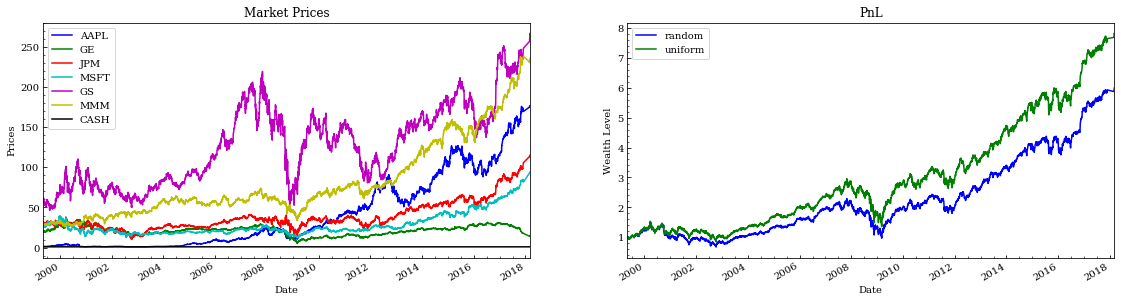

In [13]:
# agents PnL
print(f"random agent PnL: {random_pnl}")
print(f"uniform portfolio agent PnL: {uniform_pnl}")
# agents Sharpe Ratio
print(f"random Sharpe Ratio: {random_sr}")
print(f"uniform Sharpe Ratio: {uniform_sr}")
# visualize
env.render()

## Trading Signal

Qualitative evaluation of strategy by visual inspection.
Leverage `multi-agent` framework to scatter plot the portfolio weights evolution
over time.

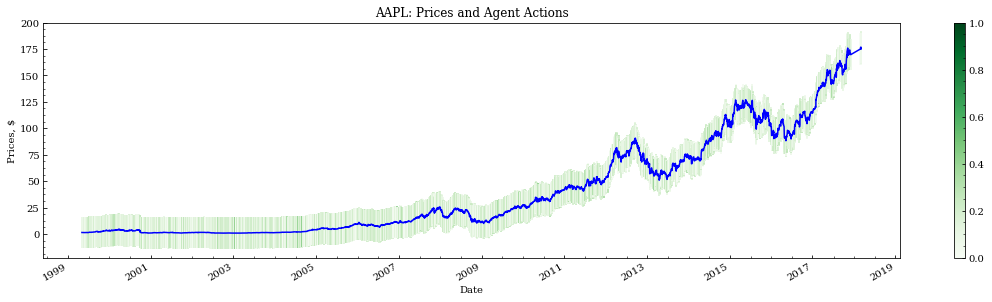

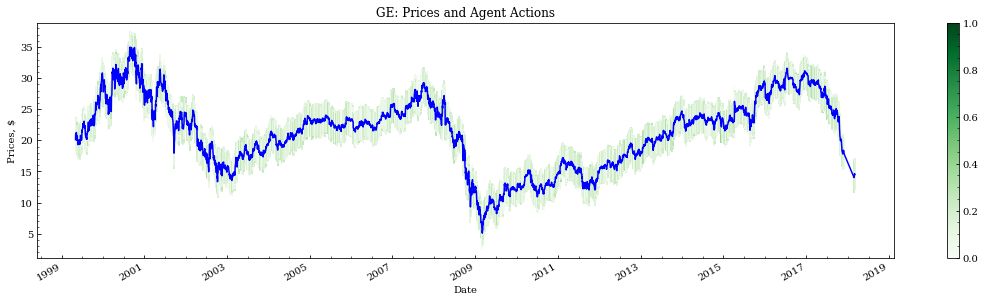

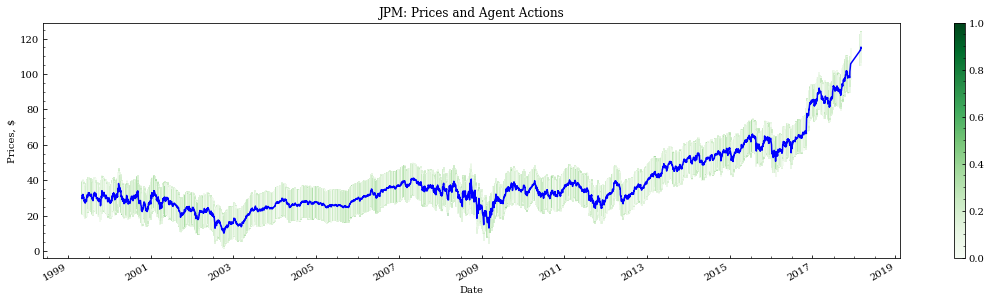

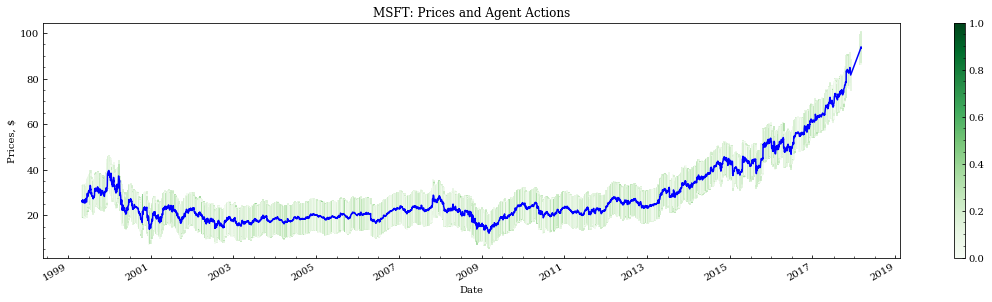

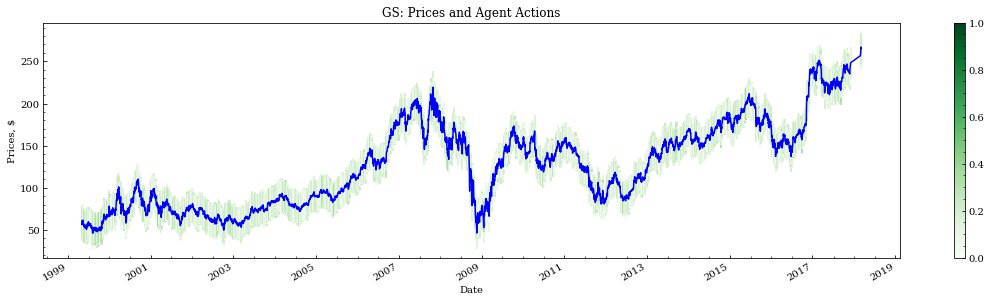

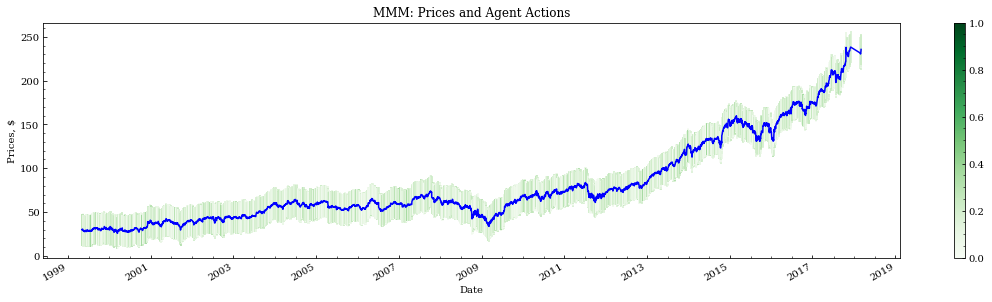

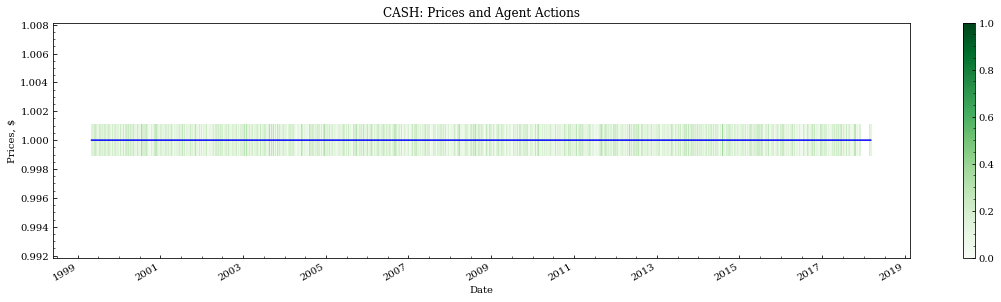

In [14]:
for asset in env.universe:
    # access episode actions
    random_actions = env.agents[random_agent.name].actions[asset]

    fig, ax = plt.subplots(figsize=(19.2, 4.8))
    env._prices[asset].plot(ax=ax)
    sc = ax.scatter(env._prices[asset].index,
                    env._prices[asset].values,
                    c=random_actions.values,
                    cmap=plt.cm.Greens,
                    marker='|',
                    s=1000,
                    vmin=0,
                    vmax=1)
    ax.set(ylabel='Prices, $', title='%s: Prices and Agent Actions' % asset)
    fig.colorbar(sc, ax=ax)